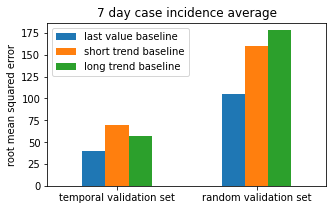

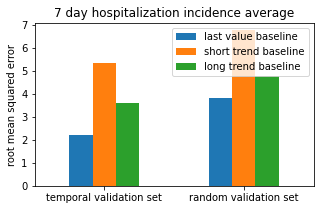

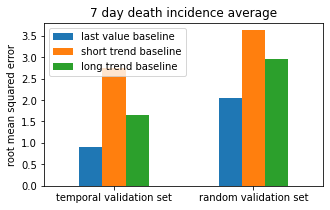

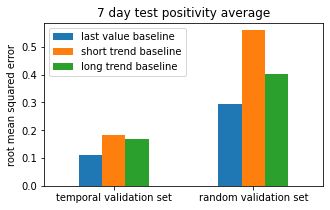

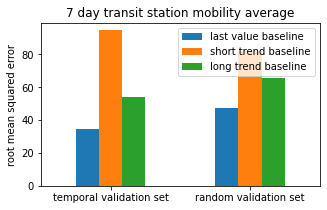

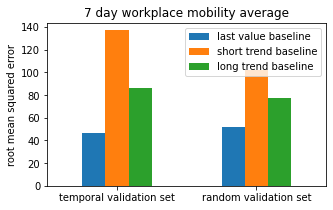

In [14]:
# THIS FILE IS TO COMPARE DIFFERENT BASELINES

import os
import pandas as pd
pd.options.display.max_rows = 10
import matplotlib.pyplot as plt
import numpy as np
import datetime
from sklearn.metrics import mean_squared_error
from joblib import dump, load
from sklearn import linear_model

from datetime import timedelta
cantonKeys = ['AG','AI','AR', 'BE', 'BL', 'BS', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'NW', 'OW', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VD', 'VS', 'ZG','ZH']




pd.options.display.max_rows = 10

data = pd.read_csv("completedata.csv")


numberOfInputWeeks = 3
numberOfOutputWeeks = 4


outputCategories = ['case_inz_entries_7dayAverage',
                  'hosp_inz_entries_7dayAverage',
                  'death_inz_entries_7dayAverage',
                  'testPositvity_7dayAverage',
                  'transit_stations_percent_change_from_baseline_7dayAverage',
                  'workplaces_percent_change_from_baseline_7dayAverage'
                   ]
numberOfOutputs = len(outputCategories)

split = numberOfOutputs * numberOfOutputWeeks + 2
train_features = data[data['category']=='train'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
train_labels = data[data['category']=='train'].iloc[:,-split:-2]
validation1_features = data[data['category']=='validation 1'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
validation1_labels = data[data['category']=='validation 1'].iloc[:,-split:-2]
validation2_features = data[data['category']=='validation 2'].iloc[:,0:-split].drop(['lastInputDay'], axis=1)
validation2_labels = data[data['category']=='validation 2'].iloc[:,-split:-2]


baselines = pd.DataFrame()

for task in outputCategories: # for all output tasks

    for outputWeekNumber in range(0,numberOfOutputWeeks): # for every output week

        # get the ground truth
        groundtruth1 = validation1_labels[["output_"+task+"_"+str(outputWeekNumber)]]
        groundtruth2 = validation2_labels[["output_"+task+"_"+str(outputWeekNumber)]]
   
        # get the easy baseline (is the same for all output weeks)
        last_value_baseline1 = validation1_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        last_value_baseline2 = validation2_features[[task+"_last_"+str(numberOfInputWeeks-1)]]
        
        # short trend baseline
        shortTrendBaseline1 = validation1_features[task +"_shortTrend_"+str(numberOfInputWeeks-1)]*(7*(outputWeekNumber+1)) + validation1_features[task+"_last_"+str(numberOfInputWeeks-1)]
        shortTrendBaseline2 = validation2_features[task +"_shortTrend_"+str(numberOfInputWeeks-1)]*(7*(outputWeekNumber+1)) + validation2_features[task+"_last_"+str(numberOfInputWeeks-1)]
        
        # long trend baseline
        longTrendBaseline1 = validation1_features[task +"_longtermTrend"]*(7*(outputWeekNumber+1)) + validation1_features[task+"_last_"+str(numberOfInputWeeks-1)]
        longTrendBaseline2 = validation2_features[task +"_longtermTrend"]*(7*(outputWeekNumber+1)) + validation2_features[task+"_last_"+str(numberOfInputWeeks-1)]
        
        last_value_baseline1_rmse = np.sqrt(mean_squared_error(last_value_baseline1,groundtruth1))
        last_value_baseline2_rmse = np.sqrt(mean_squared_error(last_value_baseline2,groundtruth2))

        shortTrendBaseline1_rmse = np.sqrt(mean_squared_error(shortTrendBaseline1,groundtruth1))
        shortTrendBaseline2_rmse = np.sqrt(mean_squared_error(shortTrendBaseline2,groundtruth2))
        
        longTrendBaseline1_rmse = np.sqrt(mean_squared_error(longTrendBaseline1,groundtruth1))
        longTrendBaseline2_rmse = np.sqrt(mean_squared_error(longTrendBaseline2,groundtruth2))

        
        res = {
                 'task':[task],
                 'week':[outputWeekNumber], 
                 'last_value_baseline1_rmse':[last_value_baseline1_rmse], 
                 'last_value_baseline2_rmse':[last_value_baseline2_rmse],
                 'shortTrendBaseline1_rmse':[shortTrendBaseline1_rmse],
                 "shortTrendBaseline2_rmse": [shortTrendBaseline2_rmse],
                 'longTrendBaseline1_rmse':[longTrendBaseline1_rmse],
                 "longTrendBaseline2_rmse": [longTrendBaseline2_rmse]
                }
        
        baselines = baselines.append(pd.DataFrame(data=res), ignore_index = True)
        
    
titlesDict = {
    'case_inz_entries_7dayAverage': '7 day case incidence average',
                  'hosp_inz_entries_7dayAverage': '7 day hospitalization incidence average',
                  'death_inz_entries_7dayAverage': '7 day death incidence average',
                  'testPositvity_7dayAverage': '7 day test positivity average',
                  'transit_stations_percent_change_from_baseline_7dayAverage': '7 day transit station mobility average',
                  'workplaces_percent_change_from_baseline_7dayAverage': '7 day workplace mobility average'
}    

for task in outputCategories:

    
    temp = baselines[baselines['task']==task].groupby(['task']).sum().drop(['week'], axis=1)
  
    t1 = temp[['last_value_baseline1_rmse', 'shortTrendBaseline1_rmse', 'longTrendBaseline1_rmse']]
    t2 = temp[['last_value_baseline2_rmse', 'shortTrendBaseline2_rmse', 'longTrendBaseline2_rmse']]
    
    t1.columns = ['last value baseline', 'short trend baseline', 'long trend baseline']
    t2.columns = ['last value baseline', 'short trend baseline', 'long trend baseline']
    
    temp = pd.concat([t1,
                      t2], 
                     ignore_index=True, axis=0)
    temp.index = ['temporal validation set', 'random validation set']

    plot = temp.plot(kind='bar', title=titlesDict[task], ylabel='root mean squared error', rot=0, figsize=(5,3))
    plt.show()
    
    if not os.path.exists('plots/baselines'):
        os.makedirs('plots/baselines')
        
    fig = plot.get_figure()
    fig.savefig('plots/baselines/baselines_'+task+'.png')


            
        
        